In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
tweets_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
tweets_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
tweets_test_infer = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(tweets_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(tweets_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(tweets_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(tweets_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [3]:
tweets_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
tweets_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
tweets_train[tweets_train['keyword'].notna()].notna().sum()

id          7552
keyword     7552
location    5080
text        7552
target      7552
dtype: int64

In [6]:
tweets_train['keyword'].value_counts()

keyword
fatalities               45
armageddon               42
deluge                   42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [7]:
import re
# List of patterns to apply
patterns = [
    r'https?://\S+',                # Remove URLs
    r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',  # Remove email addresses
    r'<.*?>',                       # Remove HTML tags
    r'[^\x00-\x7F]+',               # Remove non-ASCII characters
    r'@\w+',                        # Remove twitter handles
    r'#\w+',                        # remove hashtags
    r'[^\w\s.,]'                    # remove unwanted symbols
]

# Custom function to apply regex patterns
def clean_text(text):
    for pattern in patterns:
        text = re.sub(pattern, '', text)
    # Remove extra whitespace again after all replacements
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

# Apply the function to the 'text' column
tweets_train['text'] = tweets_train['text'].apply(clean_text)
tweets_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this may allah for...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,"13,000 people receive evacuation orders in cal...",1
4,7,NaN,NaN,just got sent this photo from ruby as smoke fr...,1
5,8,NaN,NaN,update california hwy. 20 closed in both direc...,1
6,10,NaN,NaN,heavy rain causes flash flooding of streets in...,1
7,13,NaN,NaN,im on top of the hill and i can see a fire in ...,1
8,14,NaN,NaN,theres an emergency evacuation happening now i...,1
9,15,NaN,NaN,im afraid that the tornado is coming to our ar...,1


In [8]:
text = tweets_train[tweets_train['keyword'] == 'fatalities'].text.to_list()
text = ' '.join(text).lower()

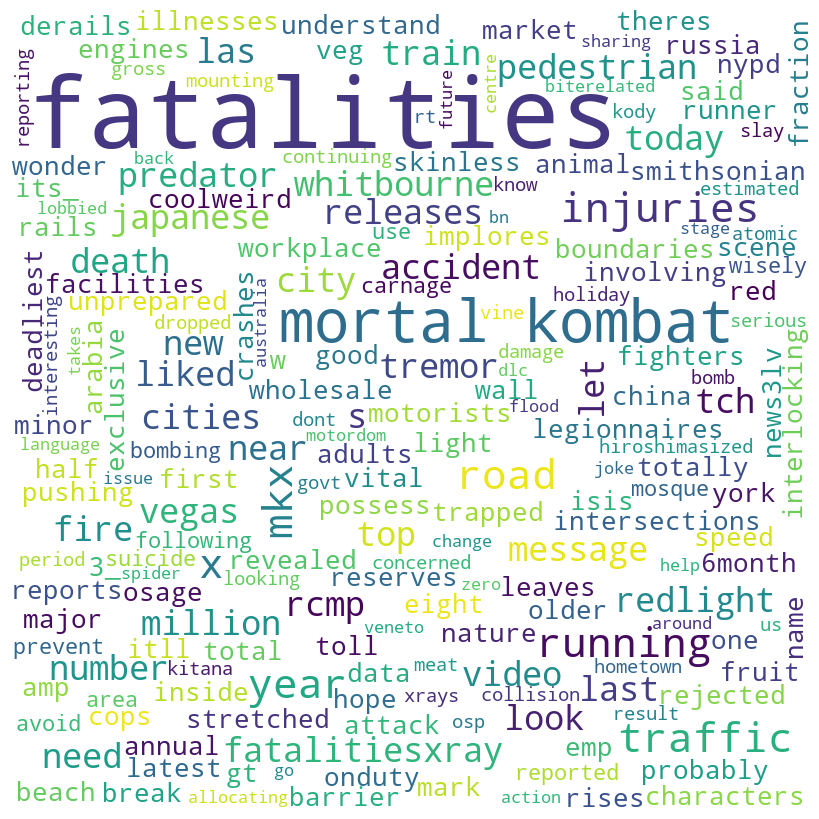

In [9]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords= STOPWORDS,
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [10]:
tweets_train.drop(['id','keyword','location'], axis=1, inplace=True)
tweets_train.rename(columns={'target':'label'}, inplace=True)
tweets_test.drop(['id','keyword','location'], axis=1, inplace=True)
tweets_test.rename(columns={'target':'label'}, inplace=True)

In [11]:
from datasets import Dataset, DatasetDict
ds_tweets_train = Dataset.from_pandas(tweets_train)
ds_tweets_test = Dataset.from_pandas(tweets_test)
display(ds_tweets_train)
display(ds_tweets_test)

Dataset({
    features: ['text', 'label'],
    num_rows: 7613
})

Dataset({
    features: ['text'],
    num_rows: 3263
})

In [12]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
model_name = 'distilbert/distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
ds_tweets_train = ds_tweets_train.shuffle(seed=42)
ds_tweets_test = ds_tweets_test.shuffle(seed=42)

In [14]:
ds_tweets_train[0:6]

{'text': ['massive typhoon heads toward taiwan.',
  'had lunch with stewart amp julian only a couple of hours earlier. good to finally find out what happened to them.',
  'seems gov moonbeam between tokes blames bush for all the fires.',
  '24 killed in two simultaneous rail crash as acute floods derail the two trains ...',
  'titan warriorcord 100 feet authentic military 550 paracord milc5040h type iii 7 strand 516 di...',
  'the 1pack 2pack 3pack line is on fleek if stretcher is fire.'],
 'label': [1, 0, 1, 1, 0, 0]}

In [15]:
tokenizer.tokenize(ds_tweets_train[0]['text'])

['massive', 'typhoon', 'heads', 'toward', 'taiwan', '.']

In [16]:
def tok_func(x): return tokenizer(x["text"])

tokenized_tweets_train = ds_tweets_train.map(tok_func, batched=True)
tokenized_tweets_test = ds_tweets_test.map(tok_func, batched=True)

Map:   0%|          | 0/7613 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [17]:
display(tokenized_tweets_train)
display(tokenized_tweets_test)

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 7613
})

Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 3263
})

In [18]:
display([len(t) for t in tokenized_tweets_train[0:3]['input_ids']])

[8, 25, 17]

In [19]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [20]:
splits = tokenized_tweets_train.train_test_split(test_size=0.2)
train_ds = splits['train']
val_ds = splits['test']

In [21]:
!pip install evaluate
import evaluate
accuracy = evaluate.load("accuracy")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.5 MB/s eta 0:00:00


In [22]:
import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [23]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [24]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_TOKEN")

In [26]:
!pip install --upgrade huggingface_hub
from huggingface_hub import login
login(secret_value_0)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.6/436.6 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.25.1
    Uninstalling huggingface-hub-0.25.1:
      Successfully uninstalled huggingface-hub-0.25.1
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [27]:
!pip install wandb
import wandb
wandb.init(mode='disabled')

In [28]:
training_args = TrainingArguments(
    output_dir="jijinAI/disaster-tweets",
    learning_rate=1e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.636206,0.774787
2,No log,0.528267,0.793828
3,0.594300,0.479505,0.806960
4,0.594300,0.462312,0.799081
5,0.594300,0.452262,0.804334
6,0.445400,0.448682,0.805647
7,0.445400,0.445685,0.805647
8,0.410200,0.443739,0.807617
9,0.410200,0.442989,0.805647
10,0.410200,0.442664,0.805647


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=1910, training_loss=0.4661663035447685, metrics={'train_runtime': 275.6321, 'train_samples_per_second': 220.947, 'train_steps_per_second': 6.93, 'total_flos': 541693344855600.0, 'train_loss': 0.4661663035447685, 'epoch': 10.0})

In [29]:
from transformers import pipeline

text = "This was a masterpiece. Not completely faithful to the books, but enthralling from beginning to end. Might be my favorite of the three."
classifier = pipeline("sentiment-analysis", model="jijinAI/disaster-tweets", device=1)
classifier(text)

[{'label': 'NEGATIVE', 'score': 0.8611029982566833}]

In [30]:
def infer_func(x): return classifier(x["text"])[0]

In [31]:
infer_func(ds_tweets_test[6])

{'label': 'NEGATIVE', 'score': 0.8637833595275879}

In [32]:
ds_tweets_test[6]['text']

'It seems that we are inundated with ideas for large #weddings. Small intimate weddings are often not highlighted... http://t.co/Jshxfvllly'

In [33]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://download.pytorch.org/whl/cu118


In [34]:
import torch
from torch.utils.data import DataLoader, TensorDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

test_texts = tweets_test_infer["text"].tolist()

inputs = tokenizer(test_texts,
                   return_tensors="pt",
                   padding="max_length",
                   truncation=True,
                   max_length=128) 


test_dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask']) 
test_dataloader = DataLoader(test_dataset, batch_size=32) 

model.eval()

predicted_labels = []  


with torch.no_grad():  
    for batch in test_dataloader:
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)  
        attention_mask = attention_mask.to(device)  
        outputs = model(input_ids, attention_mask=attention_mask)["logits"] 


        predictions = torch.argmax(outputs, dim=1) 

        predicted_labels.extend(predictions.tolist())


print(predicted_labels)


[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

In [35]:
tweets_test_infer["target"] = predicted_labels
submission_csv = tweets_test_infer.drop(columns=['keyword','location', 'text'])
submission_csv.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [36]:
submission_csv.to_csv("submission.csv",index=False)